# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [ ]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud
from sklearn import cluster

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [40]:
# using SQLite Table to read data.
con = sqlite3.connect('D:\\TGM\\ML\\AmazonFineFoodReviews\\database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      1  1303862400   
1                     0                       0      0  1346976000   
2                     1                       1      1  1219017600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality canned d...  
1      Not as Advertised  Product arrived labeled as Jumbo Salted Peanut...  
2  "Delight" says it all  This is a confection that has been around a fe...

In [41]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [42]:
print(display.shape)
display.head()

(80668, 7)


UserId   ProductId             ProfileName        Time  Score  \
0  #oc-R115TNMSPFT9I7  B007Y59HVM                 Breyton  1331510400      2   
1  #oc-R11D9D7SHXIJB9  B005HG9ET0  Louis E. Emory "hoppy"  1342396800      5   
2  #oc-R11DNU2NBKQ23Z  B007Y59HVM        Kim Cieszykowski  1348531200      1   
3  #oc-R11O5J5ZVQE25C  B005HG9ET0           Penguin Chick  1346889600      5   
4  #oc-R12KPBODL2B5ZD  B007OSBE1U   Christopher P. Presta  1348617600      1   

                                                Text  COUNT(*)  
0  Overall its just OK when considering the price...         2  
1  My wife has recurring extreme muscle spasms, u...         3  
2  This coffee is horrible and unfortunately not ...         2  
3  This will be the bottle that you grab from the...         3  
4  I didnt like this coffee. Instead of telling y...         2

In [43]:
display[display['UserId']=='AZY10LLTJ71NX']

UserId   ProductId                      ProfileName        Time  \
80638  AZY10LLTJ71NX  B006P7E5ZI  undertheshrine "undertheshrine"  1334707200   

       Score                                               Text  COUNT(*)  
80638      5  I was recommended to try green tea extract to ...         5

In [44]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [45]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

Id   ProductId         UserId      ProfileName  HelpfulnessNumerator  \
0   78445  B000HDL1RQ  AR5J8UI46CURR  Geetha Krishnan                     2   
1  138317  B000HDOPYC  AR5J8UI46CURR  Geetha Krishnan                     2   
2  138277  B000HDOPYM  AR5J8UI46CURR  Geetha Krishnan                     2   
3   73791  B000HDOPZG  AR5J8UI46CURR  Geetha Krishnan                     2   
4  155049  B000PAQ75C  AR5J8UI46CURR  Geetha Krishnan                     2   

   HelpfulnessDenominator  Score        Time  \
0                       2      5  1199577600   
1                       2      5  1199577600   
2                       2      5  1199577600   
3                       2      5  1199577600   
4                       2      5  1199577600   

                             Summary  \
0  LOACKER QUADRATINI VANILLA WAFERS   
1  LOACKER QUADRATINI VANILLA WAFERS   
2  LOACKER QUADRATINI VANILLA WAFERS   
3  LOACKER QUADRATINI VANILLA WAFERS   
4  LOACKER QUADRATINI VANILLA WAFERS   

                                                Text  
0  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
1  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
2  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
3  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
4  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...

As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [46]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [47]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [48]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [49]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

Id   ProductId          UserId              ProfileName  \
0  64422  B000MIDROQ  A161DK06JJMCYF  J. E. Stephens "Jeanne"   
1  44737  B001EQ55RW  A2V0I904FH7ABY                      Ram   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     3                       1      5  1224892800   
1                     3                       2      4  1212883200   

                                        Summary  \
0             Bought This for My Son at College   
1  Pure cocoa taste with crunchy almonds inside   

                                                Text  
0  My son loves spaghetti so I didn't hesitate or...  
1  It was almost a 'love at first bite' - the per...

In [50]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [51]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [52]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.
Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a do

In [53]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [54]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.
Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a do

In [55]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [56]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a dog would ever find in nature and if it did find rapeseed in nature and eat it, it would poison them. Today is Food industries have convinced the masses that Canola oil is a safe and even better oil than olive or virgin coconut, facts though say otherwise. Until the late 70 is it was poisonous until they figured out a way to fix that. I still like it but it could be better.


In [57]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [58]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Great ingredients although chicken should have been 1st rather than chicken broth the only thing I do not think belongs in it is Canola oil Canola or rapeseed is not someting a dog would ever find in nature and if it did find rapeseed in nature and eat it it would poison them Today is Food industries have convinced the masses that Canola oil is a safe and even better oil than olive or virgin coconut facts though say otherwise Until the late 70 is it was poisonous until they figured out a way to fix that I still like it but it could be better 


In [59]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [60]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|█████████████████████████████████████████████████████████████████████████| 364171/364171 [12:41<00:00, 478.25it/s]


In [61]:
preprocessed_reviews[1500]

'great ingredients although chicken rather chicken broth thing not think belongs canola oil canola rapeseed not someting dog would ever find nature find rapeseed nature eat would poison today food industries convinced masses canola oil safe even better oil olive virgin coconut facts though say otherwise late poisonous figured way fix still like could better'

In [62]:
final['cleaned_text']=preprocessed_reviews

In [63]:
final.shape

(364171, 11)

In [64]:
final["Score"].value_counts()

1    307061
0     57110
Name: Score, dtype: int64

In [65]:
#Getting positive and negetive data
data_pos = final[final["Score"] == 1].sample(n = 25000)
data_neg = final[final["Score"] == 0].sample(n = 25000)
final = pd.concat([data_pos, data_neg])
final.shape

(50000, 11)

In [67]:
#Sorted the data based on time and took 100k data points
final["Time"] = pd.to_datetime(final["Time"], unit = "s")
final = final1.sort_values(by = "Time")
final.head()

Id   ProductId          UserId       ProfileName  \
1146      1245  B00002Z754  A29Z5PI9BW2PU3            Robbie   
138017  149789  B00004S1C6  A1KXONFPU2XQ5K  Stephanie Manley   
138001  149770  B00004S1C5  A1KXONFPU2XQ5K  Stephanie Manley   
417901  451923  B00004CXX9   ANIMV3SPDD8SH  Guy De Federicis   
346037  374339  B00004CI84   AZRJH4JFB59VC  Lynwood E. Hines   

        HelpfulnessNumerator  HelpfulnessDenominator  Score       Time  \
1146                       7                       7      1 2000-06-23   
138017                    26                      28      1 2000-08-09   
138001                     8                       8      1 2000-08-09   
417901                     1                      12      0 2001-06-11   
346037                    21                      23      0 2001-08-08   

                                  Summary  \
1146                        Great Product   
138017                       A must have!   
138001                   Very easy to use   
417901  CASPER IS THE GHOST WITH THE MOST   
346037          Great movie, terrible DVD   

                                                     Text  \
1146    This was a really good idea and the final prod...   
138017  These are easy to use, they do not make a mess...   
138001  This are so much easier to use than the Wilson...   
417901  Michael Keaton brings no distinguishing charac...   
346037  I am continually amazed at the shoddy treatmen...   

                                             cleaned_text  
1146    really good idea final product outstanding use...  
138017  easy use not make mess offer vibrant colors no...  
138001  much easier use wilson paste colors colors vib...  
417901  michael keaton brings no distinguishing charac...  
346037  continually amazed shoddy treatment movies get...

In [180]:
X = final['cleaned_text'].values
print(X.shape)
print(type(X))

(50000,)
<class 'numpy.ndarray'>


<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [75]:
## Similartly you can do preprocessing for review summary also.

# [4] Featurization

## BAG OF WORDS

In [77]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(X)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(X)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaa', 'aaaaaahhhhhyaaaaaa', 'aaaaahhhhhhhhhhhhhhhh', 'aaaah', 'aaaand', 'aaah']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (50000, 43825)
the number of unique words  43825


## Bi-Grams and n-Grams.

In [79]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(X)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (50000, 5000)
the number of unique words including both unigrams and bigrams  5000


## [5.1] K-Means Clustering

In [80]:
#reference: https://stackoverflow.com/questions/56633739/how-to-make-word-cloud-for-each-cluster-in-kmeans
from sklearn.cluster import KMeans
def KMeansModel(vectorizer):
    inertias = []
    mapping = {} 
    K = range(1,10)

    for k in K: 
        #Building and fitting the model 
        kmeanModel = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=0)
        kmeanModel.fit(vectorizer)
        inertias.append(kmeanModel.inertia_)
    plt.plot(K, inertias, 'bx-') 
    plt.xlabel('Values of K') 
    plt.ylabel('Inertia') 
    plt.title('The Elbow Method using Inertia') 
    plt.grid()
    plt.show()

### [5.1.1] Applying K-Means Clustering on BOW,<font color='red'> SET 1</font>

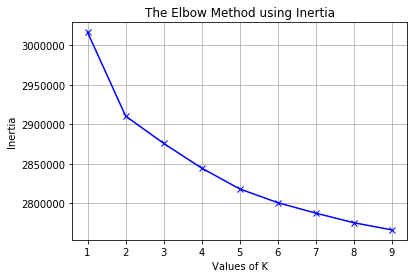

In [81]:
KMeansModel(final_bigram_counts)

In [82]:
def WordCloud_Kmeans(features, clusters):
    centroids = pd.DataFrame(clusters, columns = features)
    print(len(centroids))
    fig, axes = plt.subplots(3, 2, figsize = (40, 30))
    fig.suptitle("Top 20 words for each cluster ", fontsize = 50)
    cent = range(len(centroids))
    for ax, i in zip(axes.flat, cent):
        d = dict(centroids.iloc[i,:].sort_values(ascending = False)[0:20])
        wordcloud = WordCloud(background_color = "white").generate_from_frequencies(d)
        ax.imshow(wordcloud)
        ax.set_title("Word Cloud - Cluster {} \n".format(i+1), fontsize = 30, color='b')
        ax.axis("off")
    plt.tight_layout()
    fig.subplots_adjust(top = 0.90)
    plt.show()

### [5.1.2] Wordclouds of clusters obtained after applying k-means on BOW<font color='red'> SET 1</font>

In [83]:
kmeans_bow = KMeans(n_clusters = 5, init = 'k-means++', n_init = 10, tol = 0.0001, n_jobs = -1, random_state = 1)
y_kmeans = kmeans_bow.fit_predict(final_bigram_counts)

5


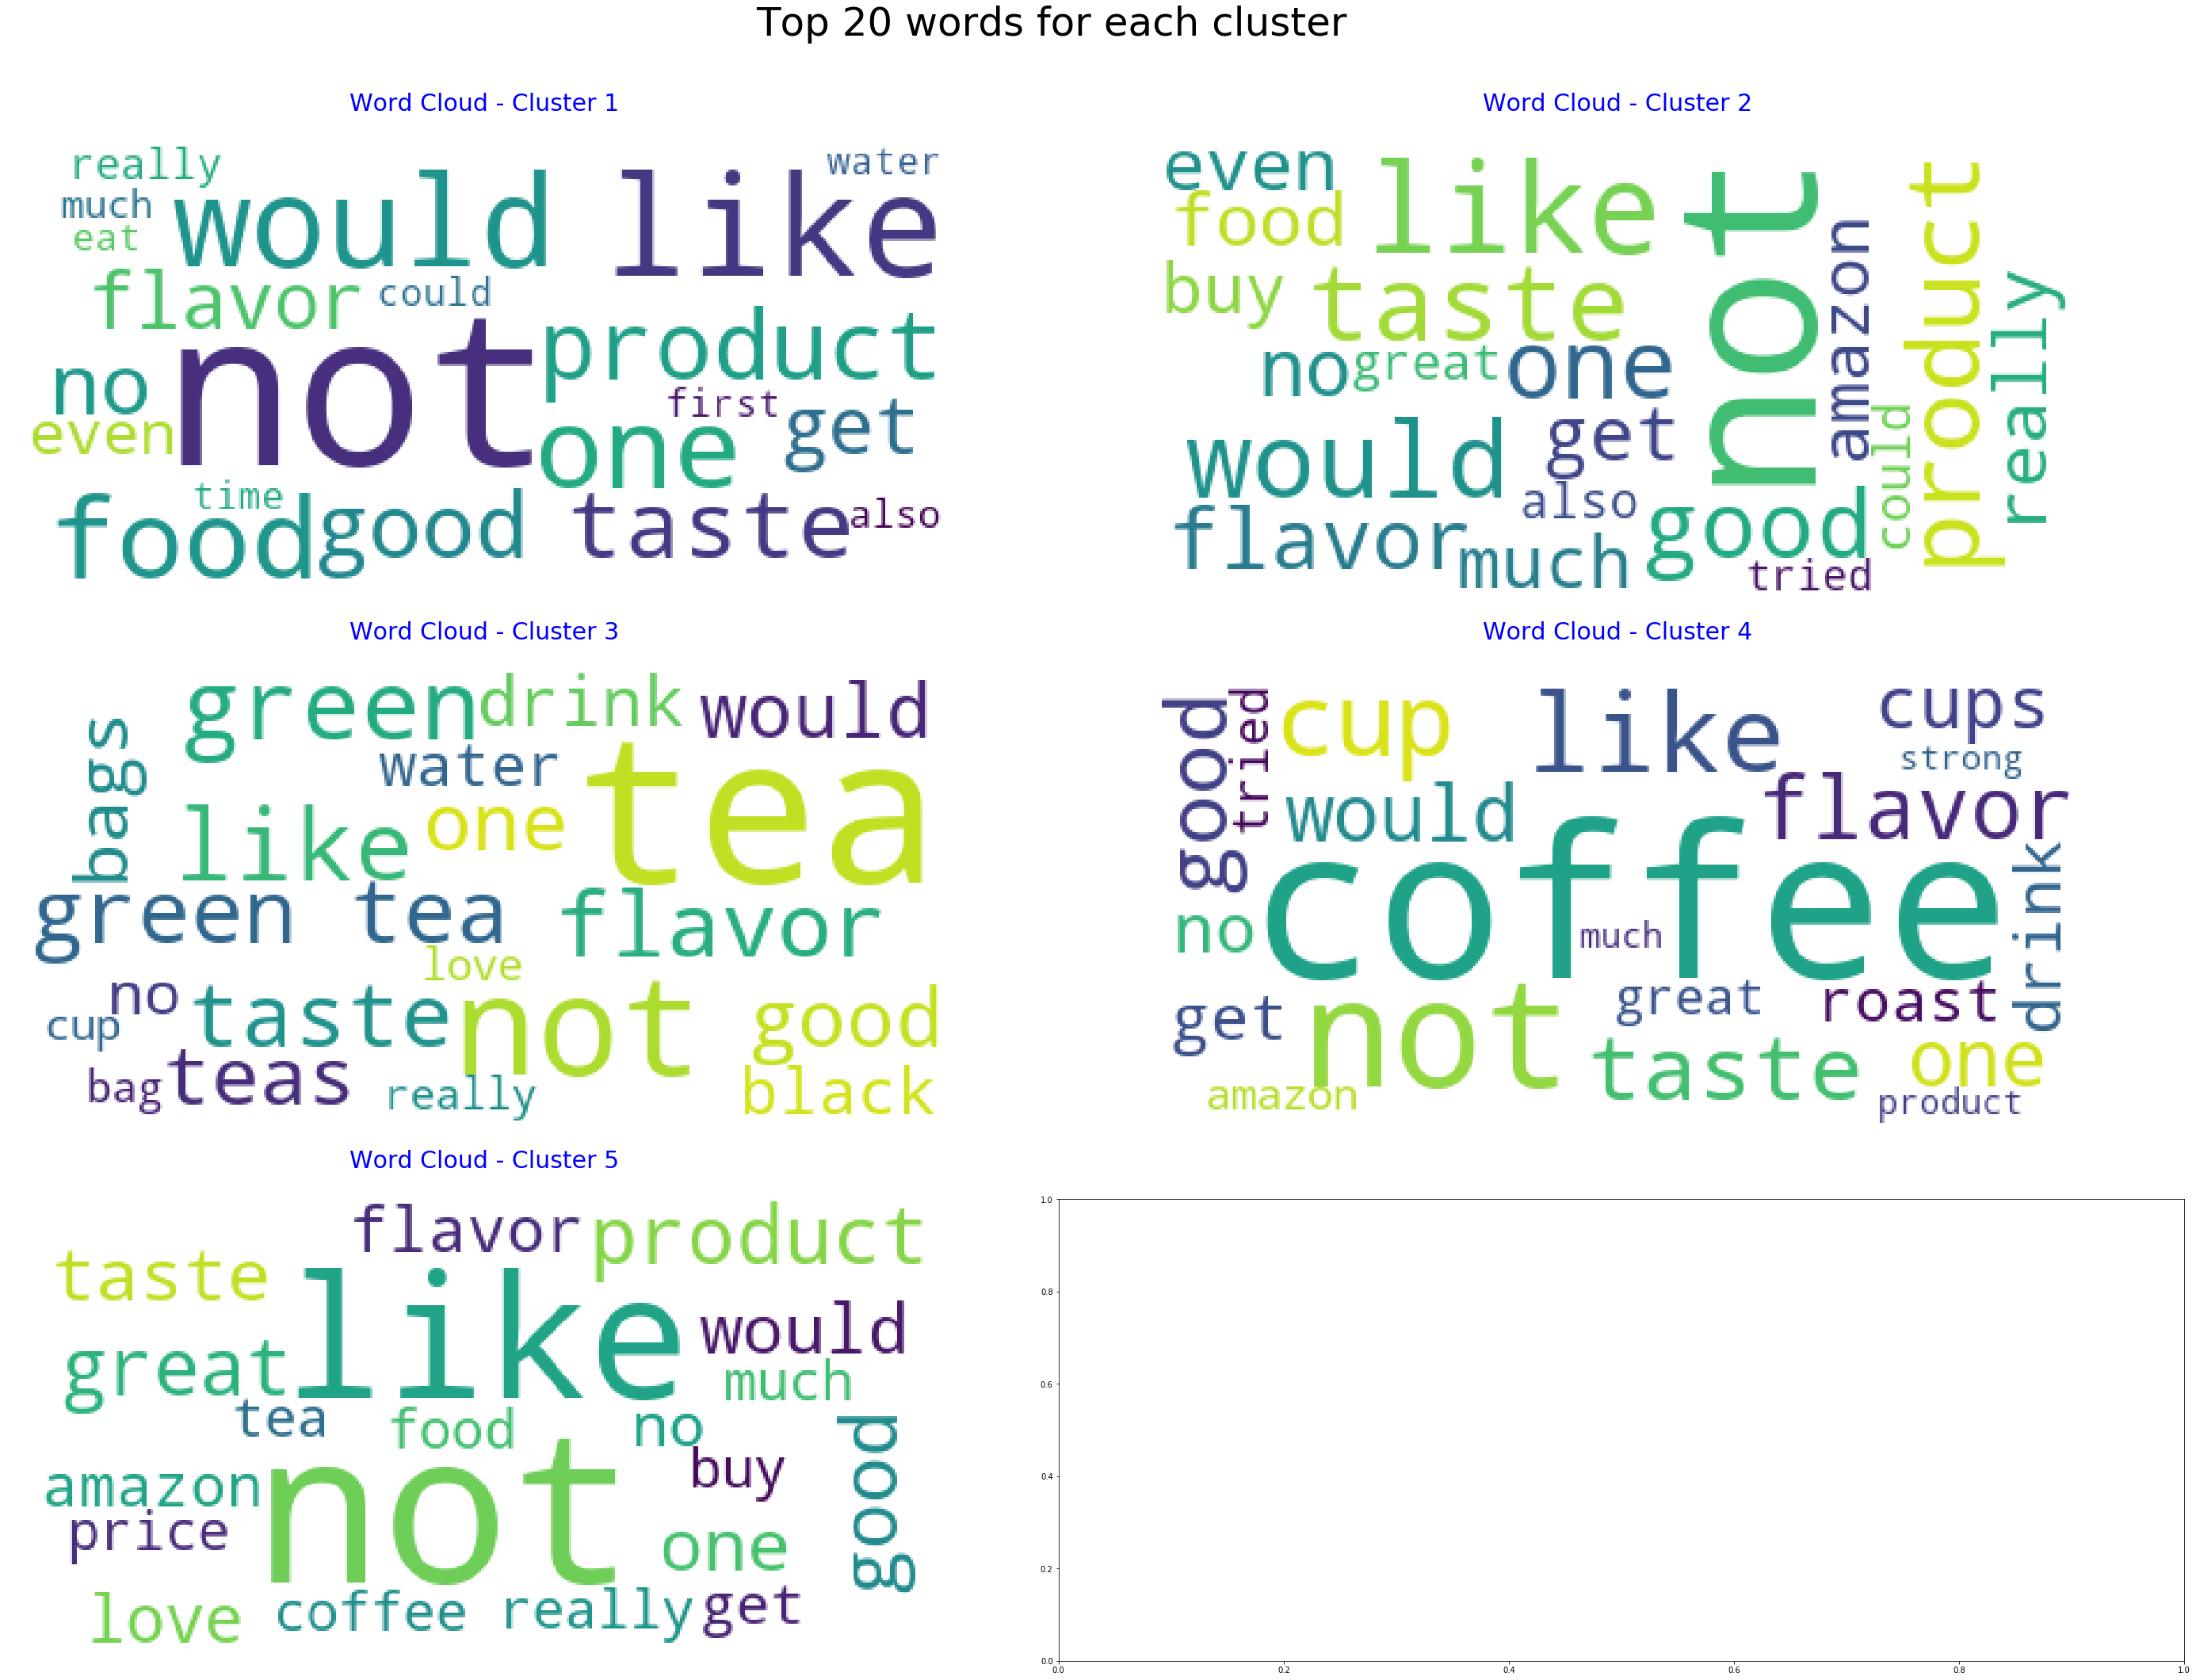

In [84]:
features = count_vect.get_feature_names()
clusters = kmeans_bow.cluster_centers_
WordCloud_Kmeans(features, clusters)

## TF-IDF

In [86]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(X)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(X)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['aa', 'abandoned', 'abdominal', 'ability', 'able', 'able buy', 'able chew', 'able drink', 'able eat', 'able enjoy']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (50000, 29772)
the number of unique words including both unigrams and bigrams  29772


### [5.1.3] Applying K-Means Clustering on TFIDF,<font color='red'> SET 2</font>

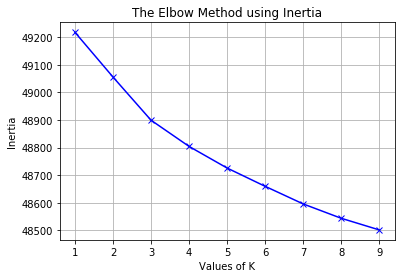

In [87]:
KMeansModel(final_tf_idf)

### [5.1.4] Wordclouds of clusters obtained after applying k-means on TFIDF<font color='red'> SET 2</font>

In [88]:
kmeans_tfidf = KMeans(n_clusters = 5, init = 'k-means++', n_init = 10, tol = 0.0001, n_jobs = -1, random_state = 1)
y_kmeans = kmeans_tfidf.fit_predict(final_tf_idf)

5


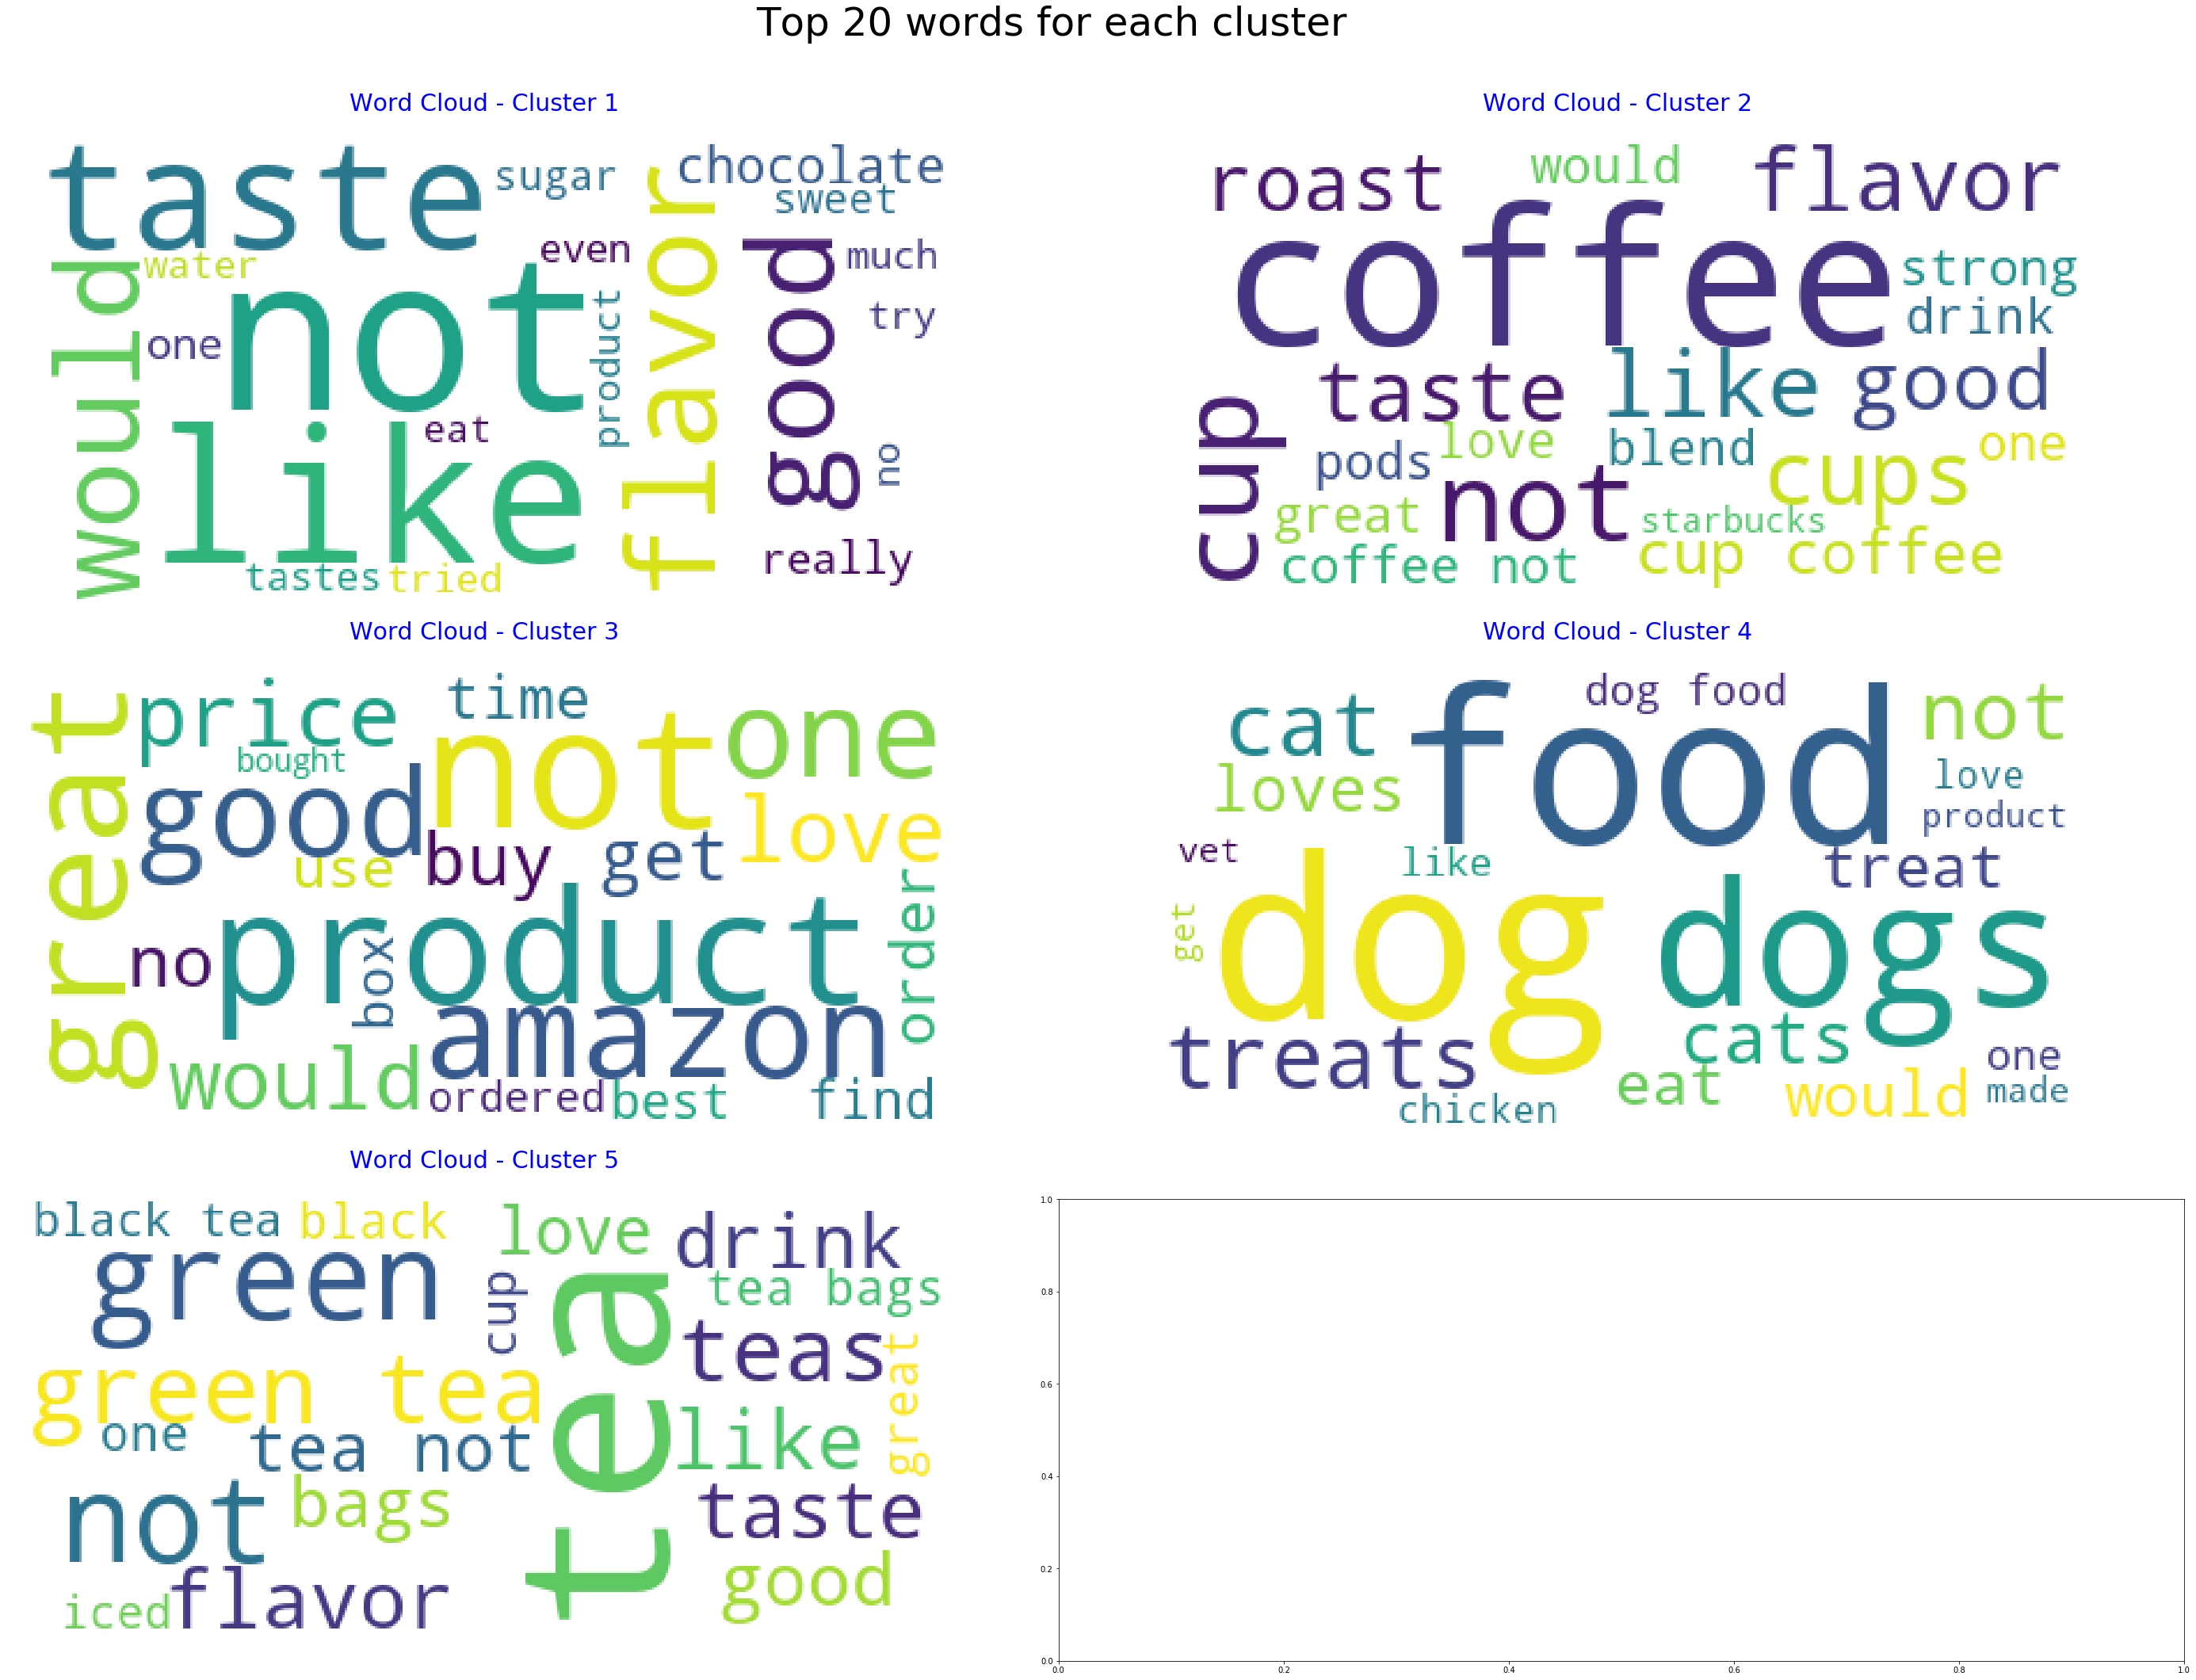

In [89]:
features = tf_idf_vect.get_feature_names()
clusters = kmeans_tfidf.cluster_centers_
WordCloud_Kmeans(features, clusters)

## Word2Vec

In [138]:
X = final["Text"]
X.shape

(50000,)

In [139]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in X:
    list_of_sentance.append(sentance.split())

In [140]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('wonderful', 0.8989290595054626), ('good', 0.8616371154785156), ('fantastic', 0.8493356704711914), ('perfect', 0.7899308204650879), ('nice', 0.7718513607978821), ('delicious', 0.7633333802223206), ('decent', 0.7568964958190918), ('excellent', 0.7248892188072205), ('awesome', 0.7107669115066528), ('great,', 0.7030574083328247)]
[('nastiest', 0.8436653017997742), ('best', 0.8225210905075073), ('WORST', 0.7041751742362976), ('BEST', 0.6940890550613403), ('closest', 0.6784470081329346), ('hottest', 0.6743845343589783), ('ever', 0.6664040088653564), ('grossest', 0.6662881970405579), ('had.', 0.6406375765800476), ('tasted.', 0.64048832654953)]


In [141]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  28386
sample words  ['This', 'was', 'a', 'really', 'good', 'idea', 'and', 'the', 'final', 'product', 'is', 'outstanding.', 'I', 'use', 'on', 'my', 'car', 'window', 'everybody', 'asks', 'where', 'i', 'bought', 'made.', 'Two', 'thumbs', 'up!', 'These', 'are', 'easy', 'to', 'use,', 'they', 'do', 'not', 'make', 'mess,', 'offer', 'vibrant', 'colors.', 'They', 'taint', 'what', 'you', 'as', 'some', 'colors', 'can.', 'would', 'highly']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

## Avg W2v

In [ ]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

In [143]:
X = np.array(sent_vectors)
X.shape

(50000, 50)

### [5.1.5] Applying K-Means Clustering on AVG W2V,<font color='red'> SET 3</font>

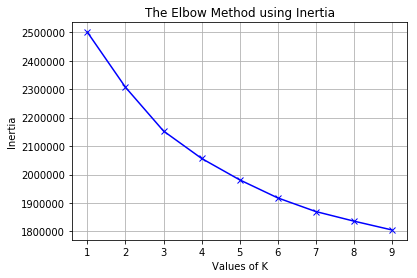

In [145]:
KMeansModel(X)

In [146]:
kmeans_w2v = KMeans(n_clusters = 5, init = 'k-means++', n_init = 10, tol = 0.0001, n_jobs = -1, random_state = 1)
y_kmeans = kmeans_w2v.fit_predict(X)

In [147]:
final.head(1)

Id   ProductId          UserId ProfileName  HelpfulnessNumerator  \
1146  1245  B00002Z754  A29Z5PI9BW2PU3      Robbie                     7   

      HelpfulnessDenominator  Score       Time        Summary  \
1146                       7      1 2000-06-23  Great Product   

                                                   Text  \
1146  This was a really good idea and the final prod...   

                                           cleaned_text  cluster_label  
1146  really good idea final product outstanding use...              0

In [148]:
final["cluster_label"] = kmeans_w2v.labels_

In [174]:
from wordcloud import WordCloud, STOPWORDS
def Word_Cloud(txt):
    # store each word from review
    cloud = " ".join(word for word in txt)
    cloud
    # Remove duplicate words
    stopwords = set(STOPWORDS) 
    # call built-in method WordCloud for creating an object for drawing a word cloud 
    wordcloud = WordCloud(width = 1000, height = 600, background_color ='white', stopwords = stopwords).generate(cloud)
    # plot the WordCloud image                        
    plt.figure(figsize = (10, 8))
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis("off") 
    plt.title("Top words for each cluster")
    plt.tight_layout(pad = 0)
  
    plt.show()

### [5.1.6] Wordclouds of clusters obtained after applying k-means on AVG W2V<font color='red'> SET 3</font>

Total number of reviews in cluster 0 is: 4241


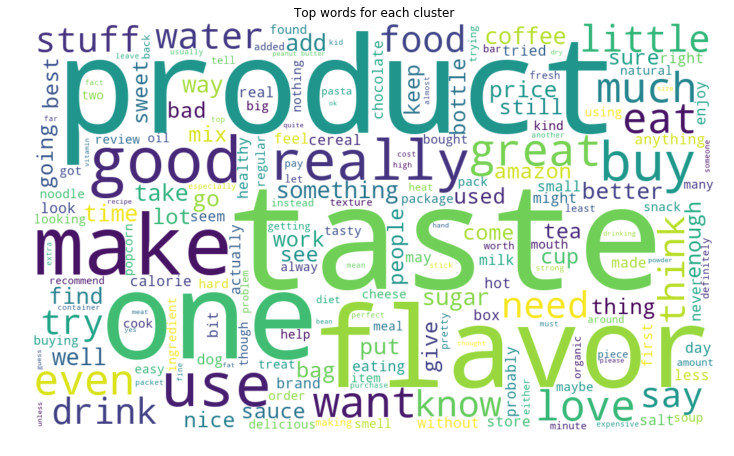

Total number of reviews in cluster 1 is: 4845


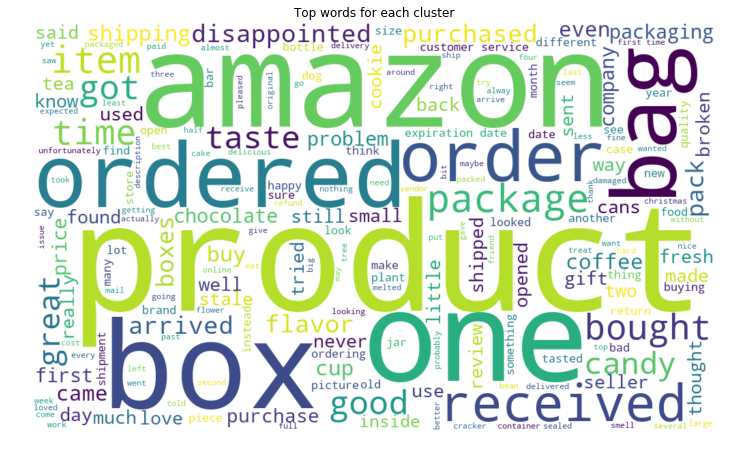

Total number of reviews in cluster 2 is: 4625


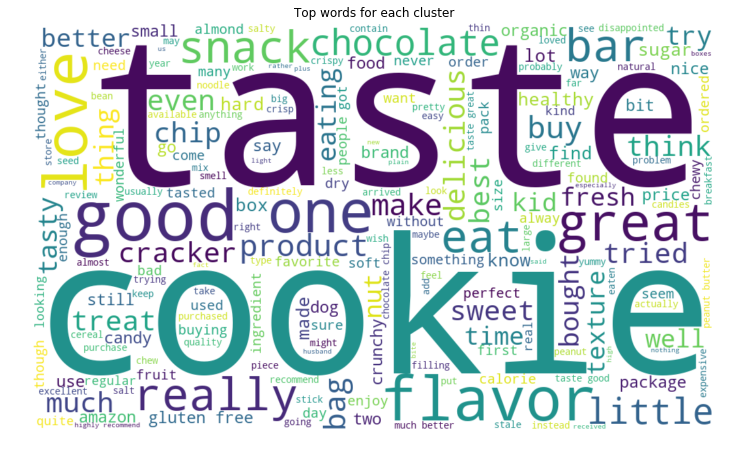

Total number of reviews in cluster 3 is: 4456


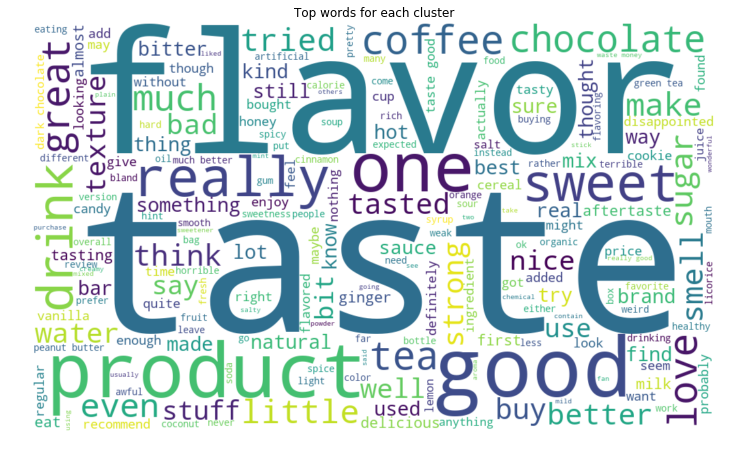

Total number of reviews in cluster 4 is: 5270


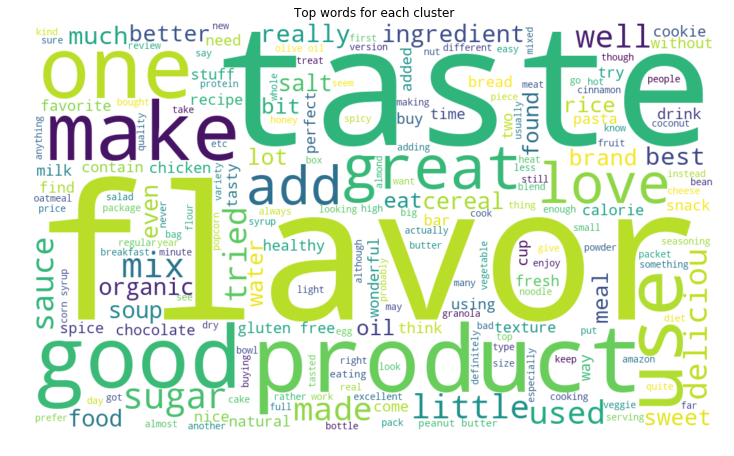

In [175]:
for i in range(kmeans_w2v.n_clusters):
    l = list()
    label = final.groupby(["cluster_label"]).groups[i]
    # For each label get the total review and put into a list(l)
    for j in range(len(label)):
        l.append(final.loc[label[j]]["cleaned_text"])
    print("Total number of reviews in cluster {} is: {}".format(i, len(label)))
    # Call Word_Cloud method 
    Word_Cloud(l)

## TFIDF weighted W2v

In [181]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [ ]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

### [5.1.7] Applying K-Means Clustering on TFIDF W2V,<font color='red'> SET 4</font>

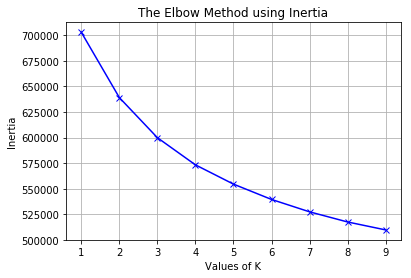

In [183]:
KMeansModel(tfidf_sent_vectors)

### [5.1.8] Wordclouds of clusters obtained after applying k-means on TFIDF W2V<font color='red'> SET 4</font>

In [184]:
kmeans_tfidfw2v = KMeans(n_clusters = 5, init = 'k-means++', n_init = 10, tol = 0.0001, n_jobs = -1, random_state = 1)
y_kmeans = kmeans_tfidfw2v.fit_predict(tf_idf_matrix)

5


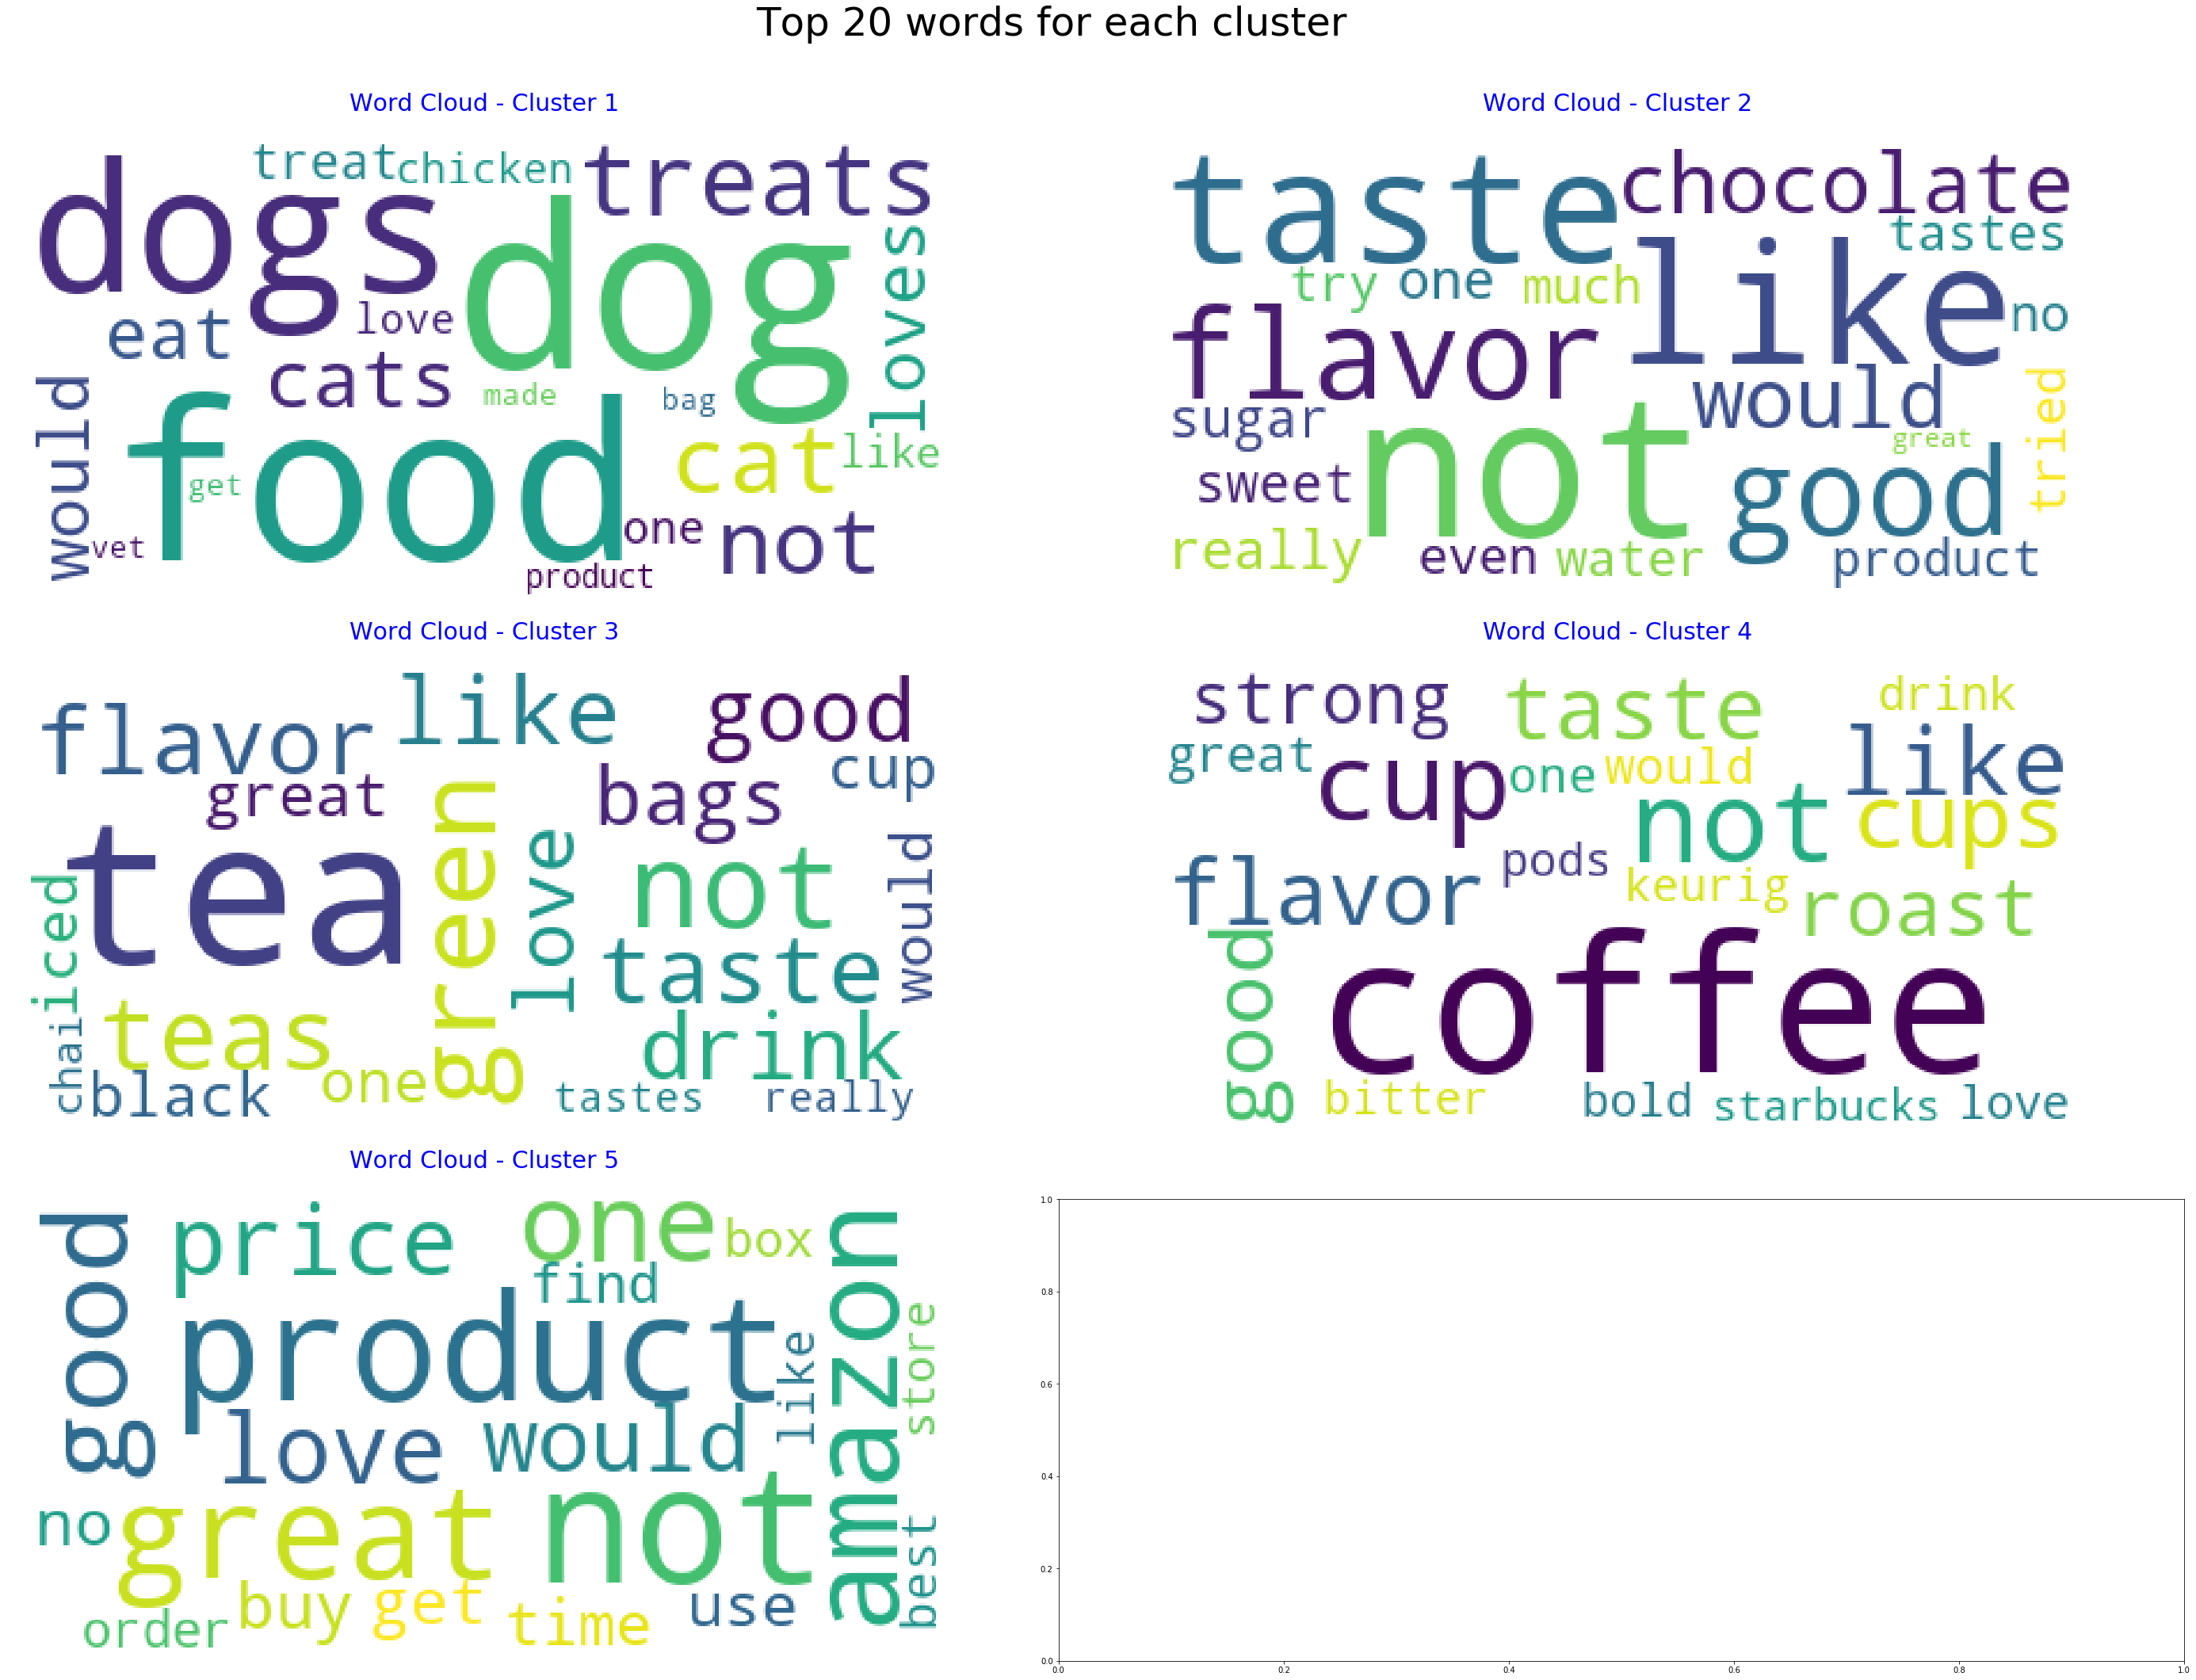

In [185]:
features = model.get_feature_names()
clusters = kmeans_tfidfw2v.cluster_centers_
WordCloud_Kmeans(features, clusters)

## [5.2] Agglomerative Clustering

In [187]:
final = final.iloc[:5000,:]
final.shape

(5000, 12)

In [188]:
X = final["Text"]
X.shape

(5000,)

## Word2Vec

In [189]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in X:
    list_of_sentance.append(sentance.split())

In [190]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('nice', 0.9504469633102417), ('wonderful', 0.9405928254127502), ('smooth.', 0.9237546920776367), ('fruity', 0.915814995765686), ('also', 0.9126725196838379), ('good', 0.9111660718917847), ('texture', 0.9101249575614929), ('strong', 0.9034608602523804), ('sweet', 0.9012753367424011), ('powerful', 0.899721086025238)]
[('Grey', 0.9810417294502258), ('favorite.', 0.9805927872657776), ('Japan.', 0.980270504951477), ('false', 0.979272186756134), ('maker.', 0.9789347052574158), ('classic', 0.9778119921684265), ('minor', 0.977512776851654), ('initial', 0.977491021156311), ('disgusting', 0.9773980379104614), ('Bar', 0.9767875075340271)]


In [191]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  5730
sample words  ['This', 'was', 'a', 'really', 'good', 'idea', 'and', 'the', 'final', 'product', 'is', 'outstanding.', 'I', 'use', 'on', 'my', 'car', 'everybody', 'where', 'i', 'bought', 'made.', 'Two', 'thumbs', 'up!', 'These', 'are', 'easy', 'to', 'use,', 'they', 'do', 'not', 'make', 'offer', 'They', 'what', 'you', 'as', 'some', 'colors', 'can.', 'would', 'highly', 'recommend', 'these', 'anyone', 'likes', 'so', 'much']


In [ ]:
## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

### [5.2.1] Applying Agglomerative Clustering on AVG W2V,<font color='red'> SET 3</font>

In [193]:
X = np.array(sent_vectors)
X.shape

(5000, 50)

### [5.2.2] Wordclouds of clusters obtained after applying Agglomerative Clustering on AVG W2V<font color='red'> SET 3</font>

## <font color='blue'> No of Clusters = 2 </font>

In [280]:
model_AC = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
model_AC.fit(X)
labels = model_AC.labels_
labels.shape

(5000,)

In [281]:
final['cluster_label'] = model_AC.labels_

In [282]:
final.head(2)

Id   ProductId          UserId       ProfileName  \
1146      1245  B00002Z754  A29Z5PI9BW2PU3            Robbie   
138017  149789  B00004S1C6  A1KXONFPU2XQ5K  Stephanie Manley   

        HelpfulnessNumerator  HelpfulnessDenominator  Score       Time  \
1146                       7                       7      1 2000-06-23   
138017                    26                      28      1 2000-08-09   

              Summary                                               Text  \
1146    Great Product  This was a really good idea and the final prod...   
138017   A must have!  These are easy to use, they do not make a mess...   

                                             cleaned_text  cluster_label  
1146    really good idea final product outstanding use...              1  
138017  easy use not make mess offer vibrant colors no...              0

Total number of reviews in cluster 0 is: 3390


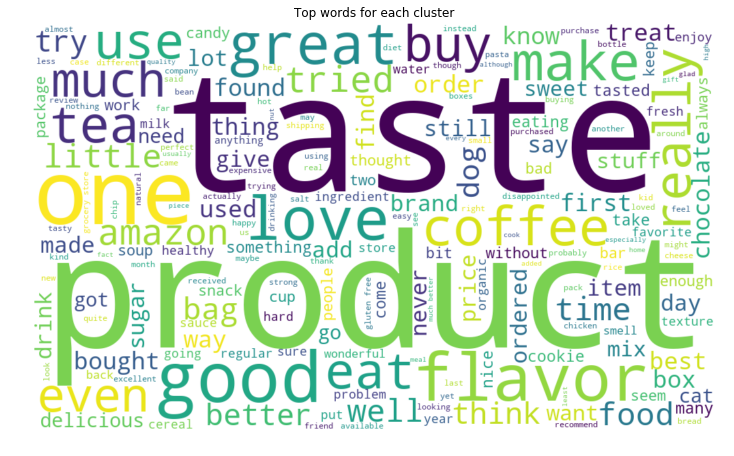

Total number of reviews in cluster 1 is: 1610


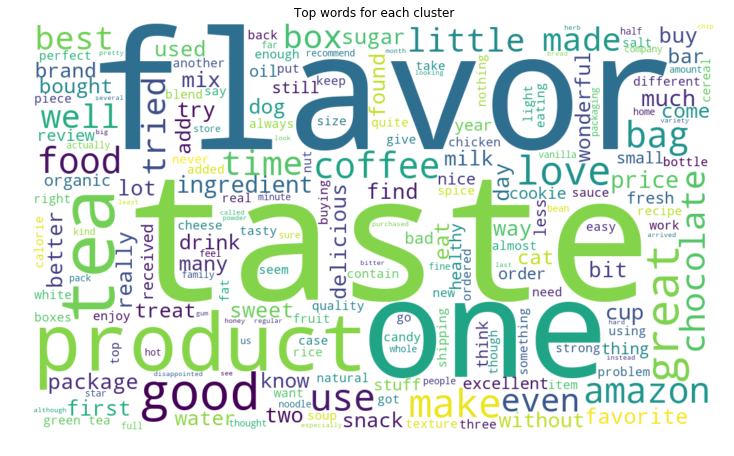

In [283]:
for i in range(model_AC.n_clusters):
    l = list()
    label = final.groupby(["cluster_label"]).groups[i]
    # For each label get the total review and put into a list(l)
    for j in range(len(label)):
        l.append(final.loc[label[j]]["cleaned_text"])
    print("Total number of reviews in cluster {} is: {}".format(i, len(label)))
    # Call Word_Cloud method 
    Word_Cloud(l)

## <font color='blue'> No of Clusters = 5 </font>

In [206]:
model_AC = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')
model_AC.fit(X)
labels = model_AC.labels_
labels.shape

(5000,)

In [207]:
final['cluster_label'] = model_AC.labels_

In [208]:
final.head(2)

Id   ProductId          UserId       ProfileName  \
1146      1245  B00002Z754  A29Z5PI9BW2PU3            Robbie   
138017  149789  B00004S1C6  A1KXONFPU2XQ5K  Stephanie Manley   

        HelpfulnessNumerator  HelpfulnessDenominator  Score       Time  \
1146                       7                       7      1 2000-06-23   
138017                    26                      28      1 2000-08-09   

              Summary                                               Text  \
1146    Great Product  This was a really good idea and the final prod...   
138017   A must have!  These are easy to use, they do not make a mess...   

                                             cleaned_text  cluster_label  
1146    really good idea final product outstanding use...              4  
138017  easy use not make mess offer vibrant colors no...              3

### [5.2.2] Wordclouds of clusters obtained after applying Agglomerative Clustering on AVG W2V<font color='red'> SET 3</font>

Total number of reviews in cluster 0 is: 1452


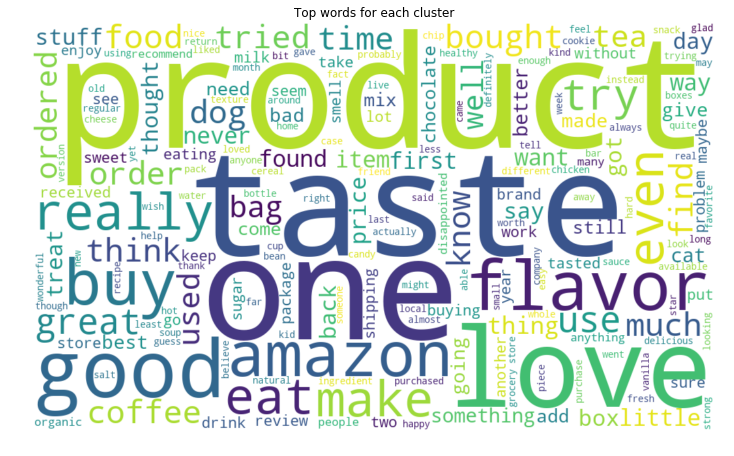

Total number of reviews in cluster 1 is: 1558


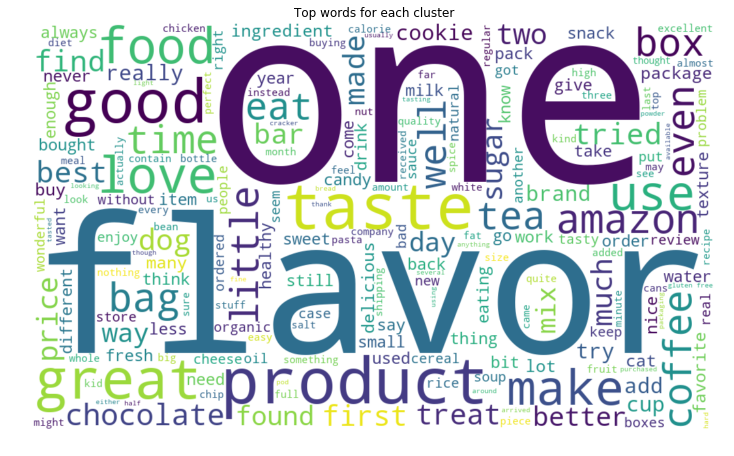

Total number of reviews in cluster 2 is: 755


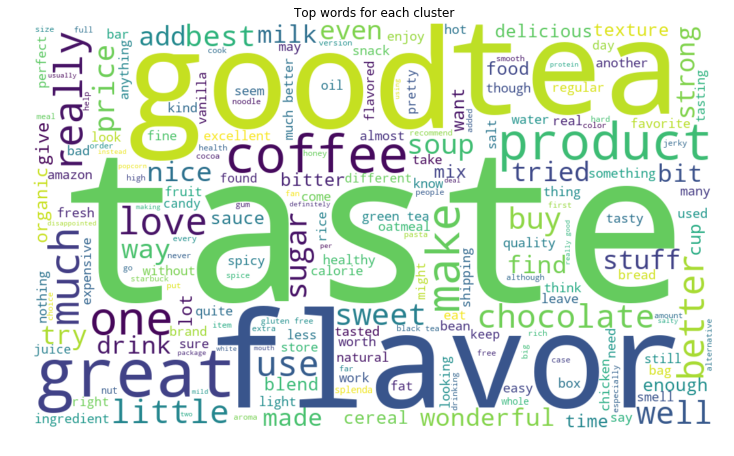

Total number of reviews in cluster 3 is: 390


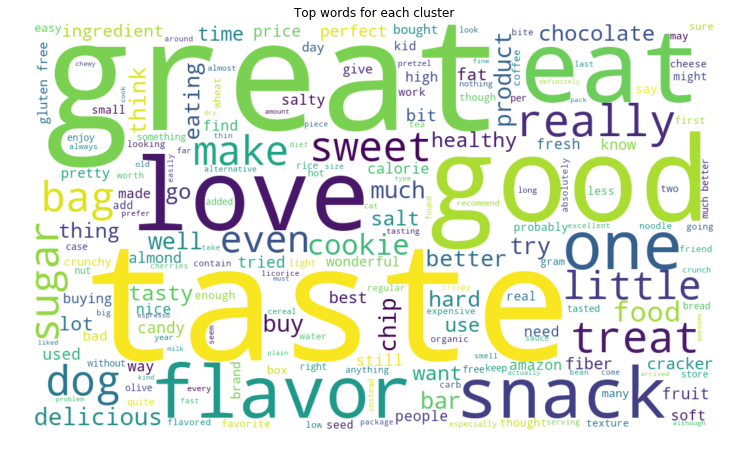

Total number of reviews in cluster 4 is: 845


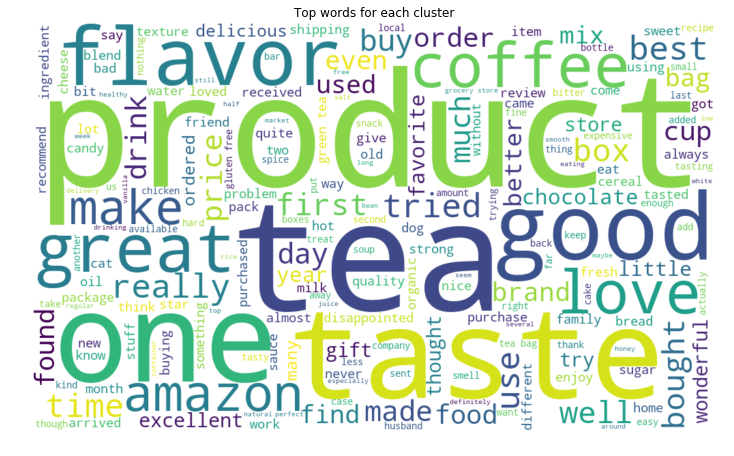

In [209]:
for i in range(model_AC.n_clusters):
    l = list()
    label = final.groupby(["cluster_label"]).groups[i]
    # For each label get the total review and put into a list(l)
    for j in range(len(label)):
        l.append(final.loc[label[j]]["cleaned_text"])
    print("Total number of reviews in cluster {} is: {}".format(i, len(label)))
    # Call Word_Cloud method to plot review in each cluster 
    Word_Cloud(l)

## TFIDF weighted W2v

In [212]:
final = final.iloc[:5000,:]
final.shape

(5000, 12)

In [213]:
X = final["Text"]
X.shape

(5000,)

In [214]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [ ]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

### [5.2.3] Applying Agglomerative Clustering on TFIDF W2V,<font color='red'> SET 4</font>

In [217]:
X = np.array(tfidf_sent_vectors)
X.shape

(5000, 50)

### [5.2.4] Wordclouds of clusters obtained after applying Agglomerative Clustering on TFIDF W2V<font color='red'> SET 4</font>

## <font color='blue'> No of Clusters = 2 </font>

In [285]:
model_AC = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
model_AC.fit(X)
labels = model_AC.labels_
labels.shape

(5000,)

In [286]:
final['cluster_label'] = model_AC.labels_

Total number of reviews in cluster 0 is: 3390


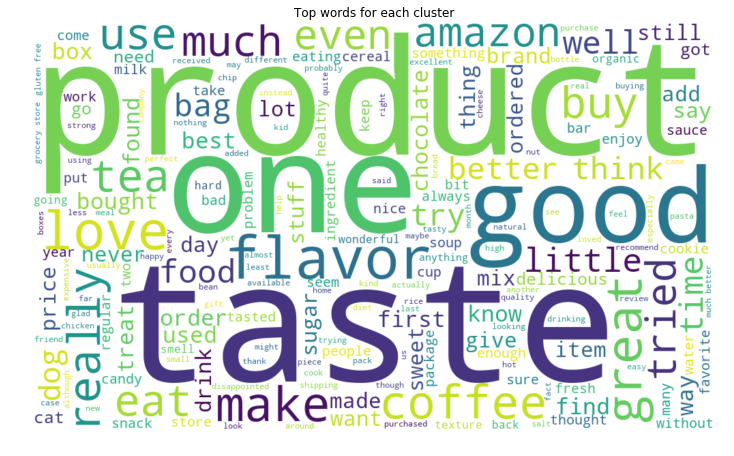

Total number of reviews in cluster 1 is: 1610


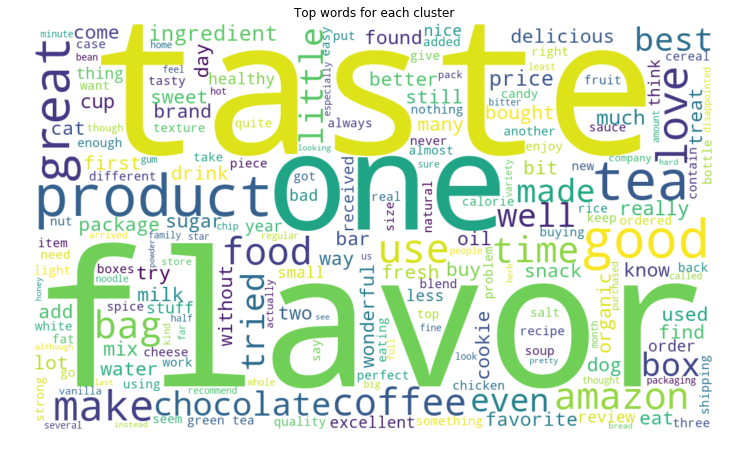

In [287]:
for i in range(model_AC.n_clusters):
    l = list()
    label = final.groupby(["cluster_label"]).groups[i]
    # For each label get the total review and put into a list(l)
    for j in range(len(label)):
        l.append(final.loc[label[j]]["cleaned_text"])
    print("Total number of reviews in cluster {} is: {}".format(i, len(label)))
    # Call Word_Cloud method 
    Word_Cloud(l)

## <font color='blue'> No of Clusters = 5 </font>

In [218]:
model_AC = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')
model_AC.fit(X)
labels = model_AC.labels_
labels.shape

(5000,)

In [219]:
final['cluster_label'] = model_AC.labels_

### [5.2.4] Wordclouds of clusters obtained after applying Agglomerative Clustering on TFIDF W2V<font color='red'> SET 4</font>

Total number of reviews in cluster 0 is: 1695


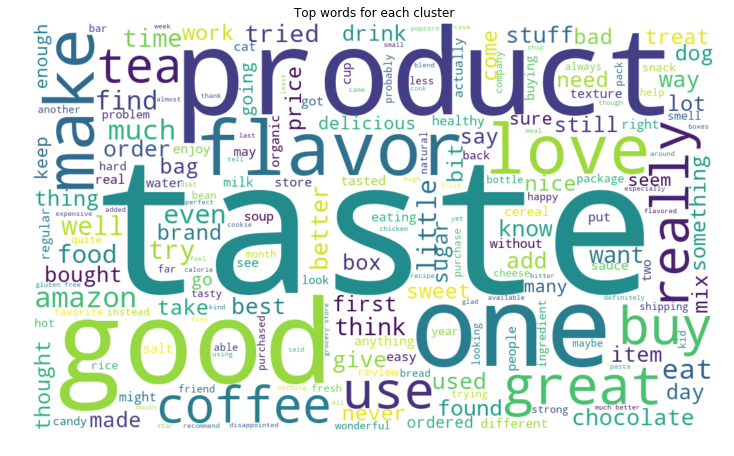

Total number of reviews in cluster 1 is: 1807


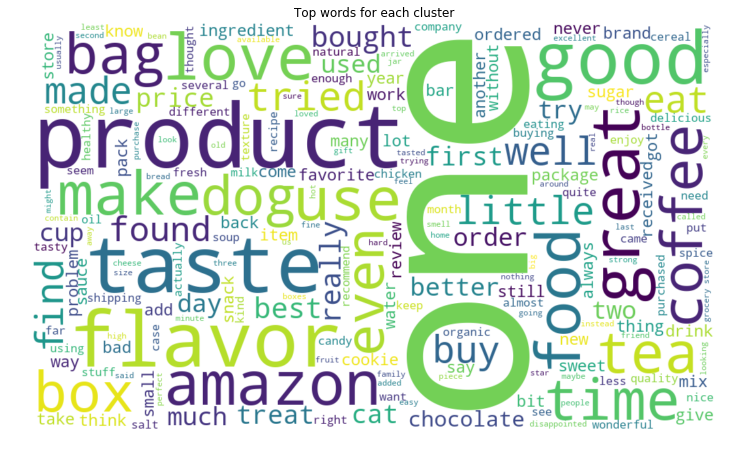

Total number of reviews in cluster 2 is: 899


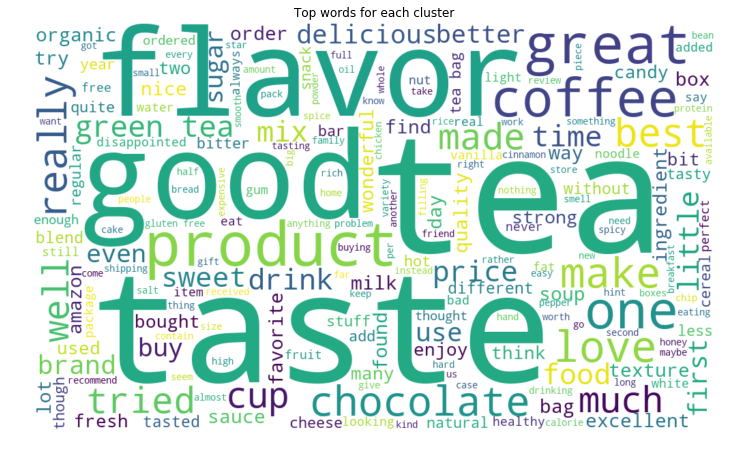

Total number of reviews in cluster 3 is: 44


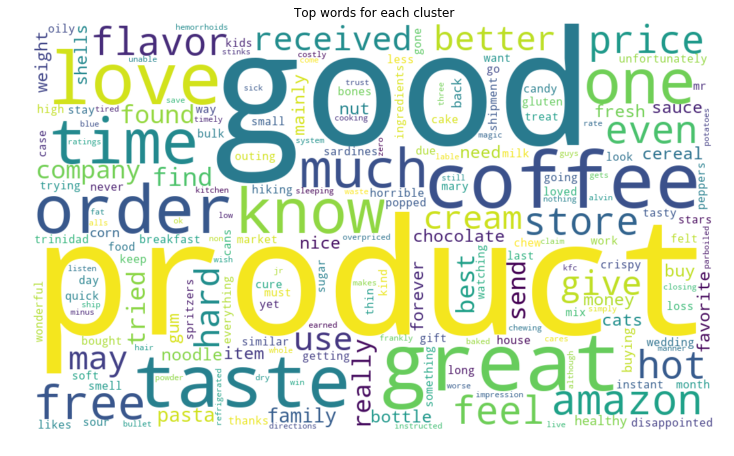

Total number of reviews in cluster 4 is: 555


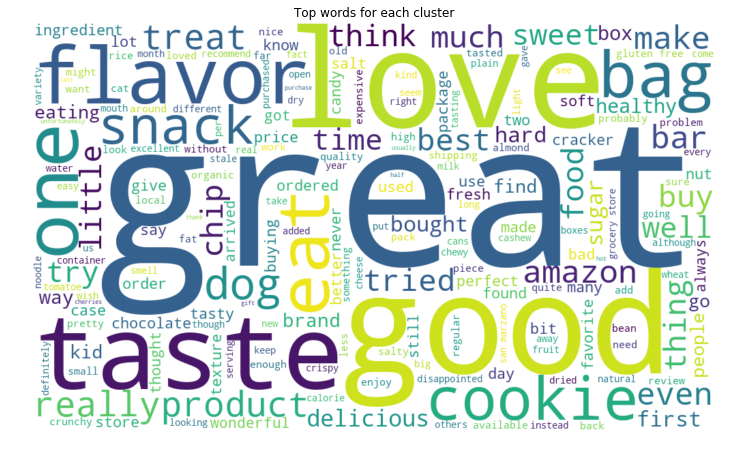

In [220]:
for i in range(model_AC.n_clusters):
    l = list()
    label = final.groupby(["cluster_label"]).groups[i]
    # For each label get the total review and put into a list(l)
    for j in range(len(label)):
        l.append(final.loc[label[j]]["cleaned_text"])
    print("Total number of reviews in cluster {} is: {}".format(i, len(label)))
    # Call Word_Cloud method 
    Word_Cloud(l)

## [5.3] DBSCAN Clustering

## Word2Vec

In [222]:
final = final.iloc[:5000,:]
final.shape

(5000, 12)

In [223]:
X = final["Text"]
X.shape

(5000,)

In [224]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in X:
    list_of_sentance.append(sentance.split())

In [225]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('nice', 0.9476532340049744), ('wonderful', 0.922637939453125), ('sturdy', 0.9186652302742004), ('sweet', 0.9145181775093079), ('pleasant.', 0.9135351777076721), ('texture', 0.909752368927002), ('good', 0.9038246870040894), ('strong', 0.9013031721115112), ('also', 0.8954638242721558), ('bit', 0.891994059085846)]
[('Grey', 0.9829393625259399), ('minor', 0.9816787242889404), ('packing', 0.9789228439331055), ('favorite.', 0.9780539274215698), ('child', 0.9778730869293213), ('maker', 0.9777446389198303), ('cereal', 0.9773275852203369), ('experience', 0.9756872653961182), ('reviews.', 0.9753183722496033), ('seller', 0.974925696849823)]


In [226]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  5730
sample words  ['This', 'was', 'a', 'really', 'good', 'idea', 'and', 'the', 'final', 'product', 'is', 'outstanding.', 'I', 'use', 'on', 'my', 'car', 'everybody', 'where', 'i', 'bought', 'made.', 'Two', 'thumbs', 'up!', 'These', 'are', 'easy', 'to', 'use,', 'they', 'do', 'not', 'make', 'offer', 'They', 'what', 'you', 'as', 'some', 'colors', 'can.', 'would', 'highly', 'recommend', 'these', 'anyone', 'likes', 'so', 'much']


## Avg W2v

In [ ]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

In [229]:
X = np.array(sent_vectors)
X.shape

(5000, 50)

In [251]:
from sklearn.neighbors import NearestNeighbors
d = {}
neigh = NearestNeighbors(n_neighbors = 100, metric = "euclidean")
neigh.fit(X)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='euclidean',
                 metric_params=None, n_jobs=None, n_neighbors=100, p=2,
                 radius=1.0)

In [252]:
neigh_dist = clf.kneighbors(n_neighbors = 100, return_distance = True)
neigh_ind = np.array(neigh_dist)

### [5.3.1] Applying DBSCAN on AVG W2V,<font color='red'> SET 3</font>

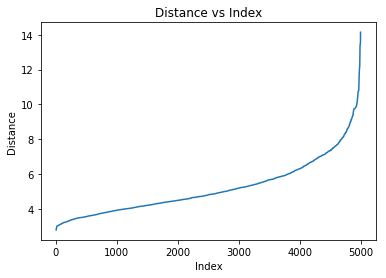

In [253]:
for dist, indx in zip(neigh_dist[0], neigh_dist[1]):
    d[indx[-1]] = dist[-1]
sort_list = sorted((value,key) for (key, value) in d.items())
distance = []
index = []
for d, i in sort_list:
    distance.append(d)
    index.append(i)
plt.plot(sorted(index), distance)
plt.title("Distance vs Index")
plt.xlabel("Index")
plt.ylabel("Distance")
plt.show()

### [5.3.2] Wordclouds of clusters obtained after applying DBSCAN on AVG W2V<font color='red'> SET 3</font>

In [273]:
from sklearn.cluster import DBSCAN
#with the reference: https://stackoverflow.com/questions/41793963/dbscan-clustering-python-cluster-words

clustering = DBSCAN(eps=10, min_samples=100).fit(X)
core_samples_mask = np.zeros_like(clustering.labels_, dtype=bool)
core_samples_mask[clustering.core_sample_indices_] = True
labels = clustering.labels_

In [274]:
final["cluster_label"] = clustering.labels_

In [275]:
final.head(1)

Id   ProductId          UserId ProfileName  HelpfulnessNumerator  \
1146  1245  B00002Z754  A29Z5PI9BW2PU3      Robbie                     7   

      HelpfulnessDenominator  Score       Time        Summary  \
1146                       7      1 2000-06-23  Great Product   

                                                   Text  \
1146  This was a really good idea and the final prod...   

                                           cleaned_text  cluster_label  
1146  really good idea final product outstanding use...              0

In [276]:
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % n_clusters_)

Estimated number of clusters: 1


Total number of reviews in cluster 0 is: 5000


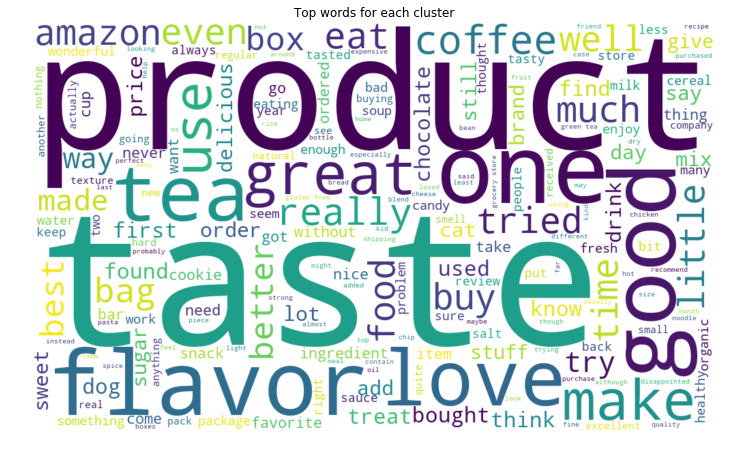

In [278]:
for i in range(n_clusters_):
    l = list()
    label = final.groupby(["cluster_label"]).groups[i]
    # For each label get the total review and put into a list(l)
    for j in range(len(label)):
        l.append(final.loc[label[j]]["cleaned_text"])
    print("Total number of reviews in cluster {} is: {}".format(i, len(label)))
    # Call Word_Cloud method 
    Word_Cloud(l)

### Observation

Found one cluster and all the words represented in one cluster and plotted the word cloud.

## TFIDF weighted W2v

In [247]:
final = final.iloc[:5000,:]
final.shape

(5000, 12)

In [248]:
X = final["Text"]
X.shape

(5000,)

In [ ]:
 # S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

### [5.3.3] Applying DBSCAN on TFIDF W2V,<font color='red'> SET 4</font>

In [250]:
X = np.array(tfidf_sent_vectors)
X.shape

(5000, 50)

In [263]:
d = {}
neigh = NearestNeighbors(n_neighbors = 100, metric = "euclidean")
neigh.fit(X)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='euclidean',
                 metric_params=None, n_jobs=None, n_neighbors=100, p=2,
                 radius=1.0)

In [264]:
neigh_dist = clf.kneighbors(n_neighbors = 100, return_distance = True)
neigh_ind = np.array(neigh_dist)

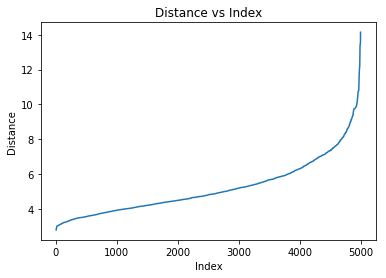

In [265]:
for dist, indx in zip(neigh_dist[0], neigh_dist[1]):
    d[indx[-1]] = dist[-1]
sort_list = sorted((value,key) for (key, value) in d.items())
distance = []
index = []
for d, i in sort_list:
    distance.append(d)
    index.append(i)
plt.plot(sorted(index), distance)
plt.title("Distance vs Index")
plt.xlabel("Index")
plt.ylabel("Distance")
plt.show()

### [5.3.4] Wordclouds of clusters obtained after applying DBSCAN on TFIDF W2V<font color='red'> SET 4</font>

In [267]:
#with the reference: https://stackoverflow.com/questions/41793963/dbscan-clustering-python-cluster-words

clustering = DBSCAN(eps=10, min_samples=100).fit(X)
core_samples_mask = np.zeros_like(clustering.labels_, dtype=bool)
core_samples_mask[clustering.core_sample_indices_] = True
labels = clustering.labels_

In [270]:
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % n_clusters_)

Estimated number of clusters: 1


Total number of reviews in cluster 0 is: 5000


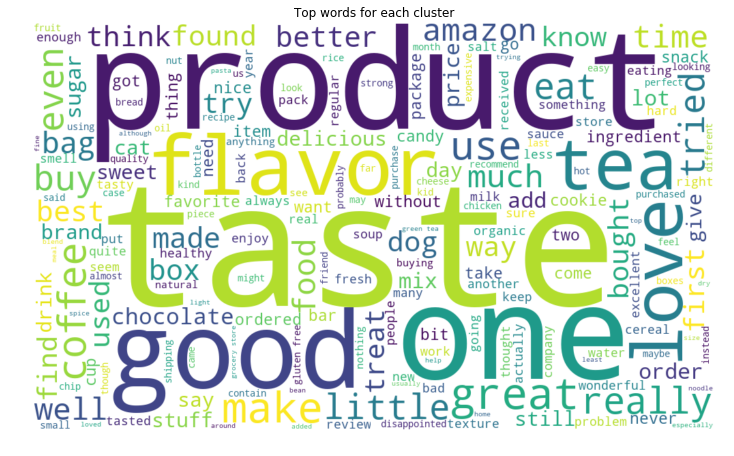

In [272]:
for i in range(n_clusters_):
    l = list()
    label = final.groupby(["cluster_label"]).groups[i]
    # For each label get the total review and put into a list(l)
    for j in range(len(label)):
        l.append(final.loc[label[j]]["cleaned_text"])
    print("Total number of reviews in cluster {} is: {}".format(i, len(label)))
    # Call Word_Cloud method 
    Word_Cloud(l)

# [6] Conclusions

1. Applied K-Means on each vectorizer BOW, TF-IDF, AVGW2V, TF-IDF W2V and considered 50,000 reviews only.
2. The best K found by Elbow Method using inertia.
3. Plotted the Word Cloud per each cluster.
4. Applied Agglomerative clustering on AVGW2V and TFIDFW2V vectorizer and considered 5000 reviews only.
5. Plotted the word cloud for each no.of. Clusters 2 and 5. 
6. Applied DBSCAN Clustering on AVGW2V and TFIDFW2V Vectrozier and considered 5000 reviews only.
7. The best epsilon found using Elbow method.
8. Estimated no.of clusters found only 1 cluster and all the words represented in one cluster and plotted the word cloud.


# [5] Assignment 10: K-Means, Agglomerative & DBSCAN Clustering

<ol>
    <li><strong>Apply K-means Clustering on these feature sets:</strong>
        <ul>
    <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Find the best ‘k’ using the elbow-knee method (plot k vs inertia_)</li>
    <li>Once after you find the k clusters, plot the word cloud per each cluster so that at a single
go we can analyze the words in a cluster.</li>          
        </ul>
    </li>
    <br>
    <li><strong>Apply Agglomerative Clustering on these feature sets:</strong>
        <ul>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Apply agglomerative algorithm and try a different number of clusters like 2,5 etc.</li>
    <li>Same as that of K-means, plot word clouds for each cluster and summarize in your own words what that cluster is representing.</li>
            <li>You can take around 5000 reviews or so(as this is very computationally expensive one)</li>
        </ul>
    </li>
    <br>
    <br>
    <li><strong>Apply DBSCAN Clustering on these feature sets:</strong>
        <ul>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Find the best ‘Eps’ using the <a href='https://stackoverflow.com/questions/12893492/choosing-eps-and-minpts-for-dbscan-r/48558030#48558030'>elbow-knee method.</a></li>
    <li>Same as before, plot word clouds for each cluster and summarize in your own words what that cluster is representing.</li>
            <li>You can take around 5000 reviews for this as well.</li>
        </ul>
    </li>
</ol>